### Connect to database

In [1]:
import mysql.connector

# connect to remote db
cnx = mysql.connector.connect(user="emlyon1",
                              password="student1",
                              host="analyst-toolbelt.cn119w37trlg.eu-west-1.rds.amazonaws.com",
                              database="B2B")
cursor = cnx.cursor()

# execute mysql query, retrieve all tweets concerning alstom 
query = ("SELECT * FROM tweet WHERE searchterm = '@Alstom'")
cursor.execute(query)

# load result in python list
tweets = list(cursor)

# keep only texts
texts = list(map(lambda x: x[2], tweets))

print("Number of tweets:", len(tweets))

Number of tweets: 10567


### create a naive workcloud using wordcloud lib

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# get one single text
text = " ".join(texts)

# create a wordcloud 
wordcloud = WordCloud(width=800, height=400).generate(text)

# matplotlib image
plt.figure(figsize=(30, 30))
plt.axis("off")
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

Now we have to build a better one.
* first we have to keep only the english tweets
* then remove urls
* then remove words beginning with @ and #

### isolate same language tweets

In [3]:
# retrieve tweets where location is indicated
query = ("SELECT text FROM tweet WHERE place_id IS NOT NULL AND searchterm = '@Alstom'")

cursor.execute(query)
located_tweets = list(cursor)

print ("Number of located tweets:", len(located_tweets),". Total number of tweets:", len(tweets))

Number of located tweets: 165 . Total number of tweets: 10567


the column place_id is not null for only 1% of the data, therefore we can't use it to keep only english tweets.
We will use langdetect lib to isolate english tweets.

### language detection

In [4]:
from langdetect import detect
import collections

# detect language
langs = [ detect(text) for text in texts ]

# sort by frequency
dic = collections.Counter(langs).most_common()

# print results
for i in range(10):
    print ("language: {:s},\tnumber of tweets: {:d},\t percentage: {:.0f}%".format(dic[i][0], dic[i][1], dic[i][1] / len(langs) * 100))

language: en,	number of tweets: 6514,	 percentage: 62%
language: fr,	number of tweets: 1935,	 percentage: 18%
language: es,	number of tweets: 783,	 percentage: 7%
language: ar,	number of tweets: 609,	 percentage: 6%
language: de,	number of tweets: 174,	 percentage: 2%
language: ca,	number of tweets: 137,	 percentage: 1%
language: pt,	number of tweets: 81,	 percentage: 1%
language: it,	number of tweets: 62,	 percentage: 1%
language: sv,	number of tweets: 62,	 percentage: 1%
language: nl,	number of tweets: 49,	 percentage: 0%


In [5]:
%%time
# We keep only english tweets, which are the more numerous.
english_text = [ text for text in texts if detect(text) == 'en' ]

CPU times: user 1min 26s, sys: 272 ms, total: 1min 26s
Wall time: 1min 26s


### Clean data : urls, words beginning with "@" and "#", and non alphanumerical characters

In [6]:
%%time

import re

# remove urls
url = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
cleaned_texts = [ re.sub(url, '', text) for text in english_text ]

# remove words beginning with #
cleaned_texts = [ re.sub(r"([#?]\w+)\b", '', text) for text in cleaned_texts ] 

# remove words beginning with @
cleaned_texts = [ re.sub(r"([@?]\w+)\b", '', text) for text in cleaned_texts ] 

# remove non-alphanumerical characters
cleaned_texts = [ re.sub(r'[^\w]', ' ', text) for text in cleaned_texts ] 

CPU times: user 120 ms, sys: 0 ns, total: 120 ms
Wall time: 122 ms


### example of clean data

In [7]:
# print differences before and after cleaning
print ("Not cleaned:\n", english_text[3])
print ("Cleaned:\n", cleaned_texts[3])

Not cleaned:
 @Alstom presenting benefits of #ERTMS, interoperable standard for #rail at Train Control Summit #Dubai @iqpcmena https://t.co/1mgzUfNtAH
Cleaned:
  presenting benefits of   interoperable standard for  at Train Control Summit   


### sorted words by frequency

In [8]:
# get the list of lowercased words
words = " ".join(cleaned_texts).lower().split()

# a little bit of more manual cleaning
irrelevant_words = [ "rt", "https" ]
words = [ word for word in words if word not in irrelevant_words ]

# print sorted list, 10 most common
dic = collections.Counter(words).most_common()
dic[:10]

[('the', 3169),
 ('in', 2133),
 ('to', 1965),
 ('of', 1928),
 ('for', 1495),
 ('a', 1485),
 ('s', 1308),
 ('new', 925),
 ('and', 911),
 ('is', 893)]

### a better wordcloud

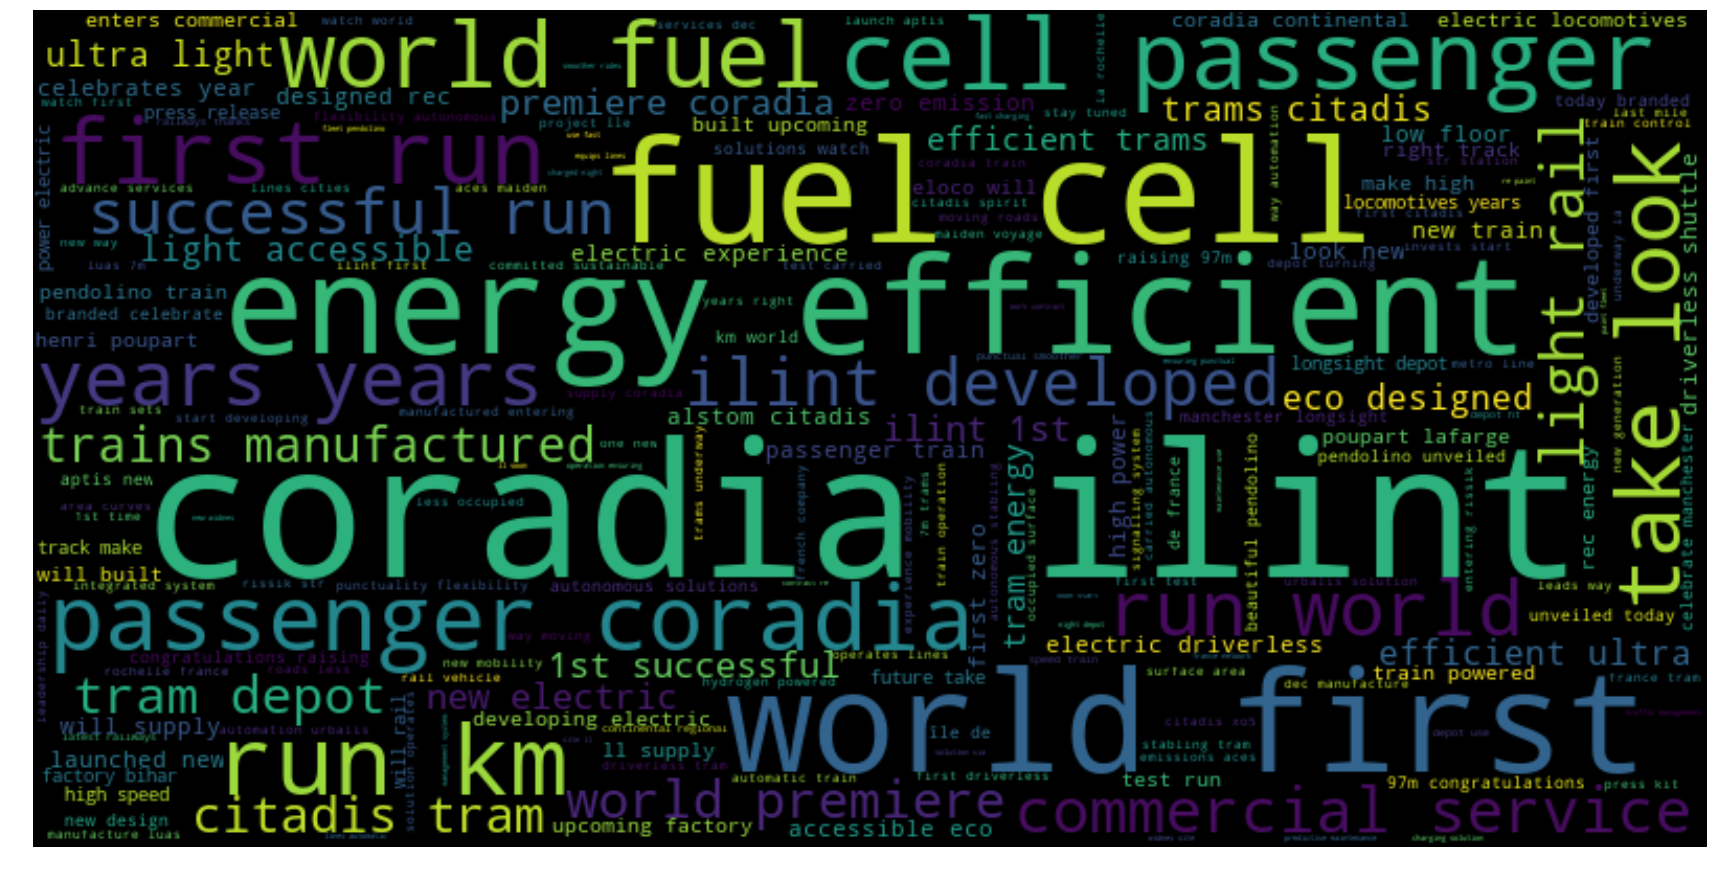

In [9]:
# create a wordcloud 
wordcloud2 = WordCloud(width=800, height=400).generate(" ".join(words))

# matplotlib image
plt.figure(figsize=(30, 30))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

In [10]:
# same with pillow
image = wordcloud2.to_image()
image.save("wordcloud-alstom.png")
